# Import required libraries

In [1]:
import os
import numpy as np
import cv2
import pickle
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib

from skimage import exposure

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.optimizers import RMSprop,Adam
import keras.backend as K
from keras.models import load_model

#local files
from model import create_model



Using TensorFlow backend.


## Data preporcessing functions

In [2]:
#%% reading from the log file and save the data into panda Data Frame
# Steerings and Throttles below drop value will not be used for training or validation
def read_frames_and_steering_from_file(data_dir,log_file_name,throttle_drop_value=0.25,steering_drop_value=0.2):
    abs_driving_log_path = os.path.join(data_dir, log_file_name)

    driving_log_file_data = pd.read_csv(abs_driving_log_path, header = None,\
            names=['center','left','right','steering','throttle','break'],index_col = False)
    
    keep_throttle_ind = driving_log_file_data['throttle'] >= throttle_drop_value
    driving_log_file_data= driving_log_file_data[keep_throttle_ind].reset_index()
    
    keep_steering_ind = abs(driving_log_file_data['steering']) >= steering_drop_value
    driving_log_file_data= driving_log_file_data[keep_steering_ind].reset_index()
    
    return driving_log_file_data
    
#%% This is the genrator for model fit_generator function, it provides the the training data.
# the output is an array of images and steering values.
#The size of the array is determined by the batch_size arguments
def generate_train_data(data_dir,data,batch_size = 32):
    
    num_samples = len(data)
    correction = 0.25 # this is a parameter to tune left and right steerings
    
    assert (batch_size <= num_samples), "change batch_size {}, only {} samples".format(batch_size,num_samples)
    while 1:
        data = shuffle(data)
        data = data.reset_index(drop=True)
        
        for offset in range(0, num_samples, batch_size):
            
            if offset+batch_size > num_samples:
                continue
            
            batch_data = data.iloc[offset:offset+batch_size].reset_index(drop=True)
            batch_center_image_path = batch_data.center
            batch_left_image_path = batch_data.left
            batch_right_image_path = batch_data.right
            batch_steering_values = np.array(batch_data.steering,dtype=np.float32)
            
            batch_images = []
            batch_steering = []
            
            for batch_idx in range(0,batch_size):
                
                center_steering = batch_steering_values[batch_idx]
                left_steering = center_steering+correction
                right_steering = center_steering-correction
                
                center_image_path = os.path.join(data_dir,batch_center_image_path[batch_idx].strip())
                
                left_image_path = os.path.join(data_dir,batch_left_image_path[batch_idx].strip())
                right_image_path = os.path.join(data_dir,batch_right_image_path[batch_idx].strip())

                assert os.path.exists(center_image_path), "center image not found at {}".format(center_image_path)
                assert os.path.exists(left_image_path), "left image not found at {}".format(left_image_path)
                assert os.path.exists(right_image_path), "right image not found at {}".format(right_image_path)

                center_image = cv2.cvtColor(cv2.imread(center_image_path),cv2.COLOR_BGR2RGB)
                if np.random.randint(2)==1:
                    center_image,center_steering = flip_image(center_image,center_steering)
                    
                left_image = cv2.cvtColor(cv2.imread(left_image_path),cv2.COLOR_BGR2RGB)
                if np.random.randint(2)==1:
                    left_image,left_steering = flip_image(left_image,left_steering)
                    
                right_image = cv2.cvtColor(cv2.imread(right_image_path),cv2.COLOR_BGR2RGB)
                if np.random.randint(2)==1:
                    right_image,right_steering = flip_image(right_image,right_steering)
                #image = image_preprocessing_pipeline(image,img_size)
                
                batch_images.extend([center_image, left_image, right_image])
                batch_steering.extend([center_steering, left_steering, right_steering])
            
            X_train_batch = np.array(batch_images)
            y_train_batch = np.array(batch_steering)
            X_train_b,y_train_b = shuffle(X_train_batch, y_train_batch)
            yield X_train_b[0:batch_size],y_train_b[0:batch_size]         

#%% This is the genrator for model fit_generator function, it provides the the validation data one by one
def generate_validation_data(data_dir,data):
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index(drop=True)
            center_image_path = line_data['center'][0]
            center_steering = np.array(line_data['steering'][0],dtype=np.float32)
            
            center_image_path = os.path.join(data_dir,center_image_path.strip())
            assert os.path.exists(center_image_path), "center image not found at{}".format(center_image_path)
            
            center_image = cv2.cvtColor(cv2.imread(center_image_path),cv2.COLOR_BGR2RGB)

            X = center_image.reshape(1, center_image.shape[0], center_image.shape[1], center_image.shape[2])
            y = np.expand_dims(center_steering,axis=0)
            yield X, y
#%% flipping the image and steering
def flip_image(image,steer):
    #image = cv2.flip(image,1)
    image_flipped = np.fliplr(image)
    flipped_steer = -steer
    
    return image_flipped,flipped_steer

## Model Visualization functions

In [3]:
# this is function to plot convolutional filters of a layer
def plot_filters(layer,x,y):
    tf_session = K.get_session()
    filters = layer.W.eval(tf_session)
    fig = plt.figure()
    for j in range(filters.shape[-1]):
        ax = fig.add_subplot(y,x,j+1)
        ax.matshow(filters[:,:,0,j],cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

# this is function process an image though the network
def get_activations(model, layer_idx, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

# this is function to plot output of a layer after passing an specific image thorough the model
def visualizing_activations(activations,x,y):
    fig = plt.figure(figsize=(8,8))
    for i in range(activations.shape[-1]):
        ax = fig.add_subplot(y,x,i+1)
        ax.imshow(activations[0,:,:,i],cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

In [4]:
img_size = (160,320)
batch_sample_size = 200

script_dir = os.getcwd() #<-- absolute dir the script is in

train_data_dir_name = "data"
train_data_dir = os.path.join(script_dir, train_data_dir_name)

driving_log_file_data = read_frames_and_steering_from_file\
(train_data_dir,"driving_log.csv",throttle_drop_value=0.25,steering_drop_value=0.05)


train_generator = generate_train_data(train_data_dir,driving_log_file_data,batch_size=batch_sample_size)
validation_generator = generate_validation_data(train_data_dir,driving_log_file_data)

**Visualizing and Checking steering data**

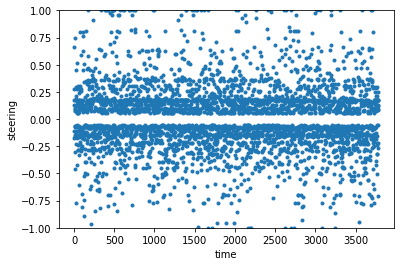

In [7]:
len_plt = len(driving_log_file_data.steering)

t_s = np.arange(len(driving_log_file_data.steering))
x_s = np.array(driving_log_file_data['steering'],dtype=np.float32)

plt.plot(t_s[0:len_plt],x_s[0:len_plt],'.');
plt.xlabel('time')
plt.ylabel('steering')
plt.ylim(-1,1);
plt.show()

#### Checking the flip function

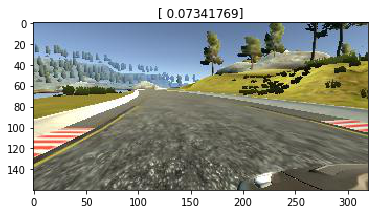

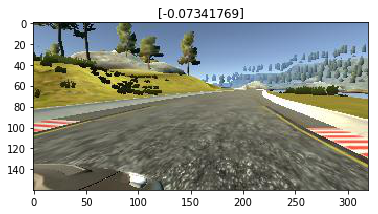

In [13]:
X_train,y_train = next(train_generator)
input_image = X_train[0:1,:,:,:]
output_str = y_train[0:1]
plt.imshow(input_image[0])
plt.title("{}".format(output_str))
plt.show()
fimg,fstr = flip_image(input_image[0],output_str)
plt.imshow(fimg)
plt.title("{}".format(fstr))
plt.show()

## Loading model and training parameters

In [8]:
#%%loading previously existing weights if exists and compiling the model
    
model_file_name = 'model.h5'
model= None
    
if os.path.exists(model_file_name):
    model = create_model(img_size)
    model.load_weights(model_file_name)
else:
    model = create_model(img_size)
        
model.compile(optimizer=Adam(lr=0.0001),loss='mean_squared_error')

print (model.summary())    

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 105, 320, 3)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 64, 128, 3)    0           cropping2d_1[0][0]               
___________________________________________________________________________________________

## Visualizing Convolutional layers for random images

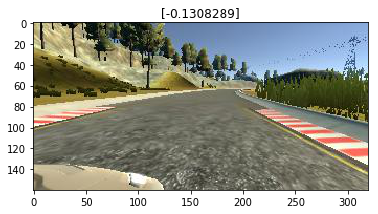

(1, 3, 11, 64)


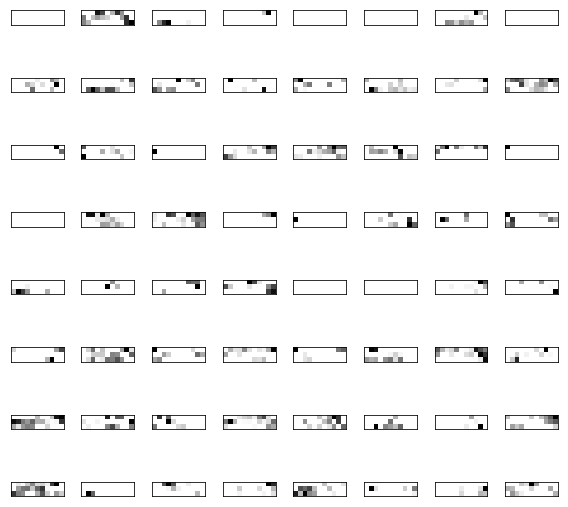

In [7]:
plt.imshow(input_image[0])
plt.title("{}".format(output_str))
plt.show()
out_layer_idx = 12
output = get_activations(model, out_layer_idx, input_image)
print(output[0].shape)
visualizing_activations(output[0],8,8).show()

## Training the network

In [8]:
#%% Training the network

nb_epoch=5
train_samples_per_epoch=40000
val_samples_per_epoch = len_plt

history = model.fit_generator(train_generator,samples_per_epoch=train_samples_per_epoch, nb_epoch=nb_epoch,\
                    verbose=1,validation_data = validation_generator,nb_val_samples=val_samples_per_epoch)

model.save_weights(model_file_name)


Epoch 1/5
40000/40000 [==============================] - 141s - loss: 0.0254 - val_loss: 0.0146

## Visualizing same layer and image after training

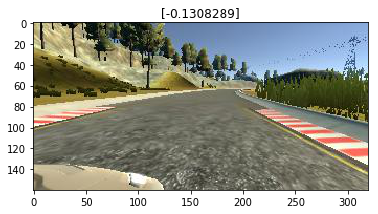

(1, 3, 11, 64)


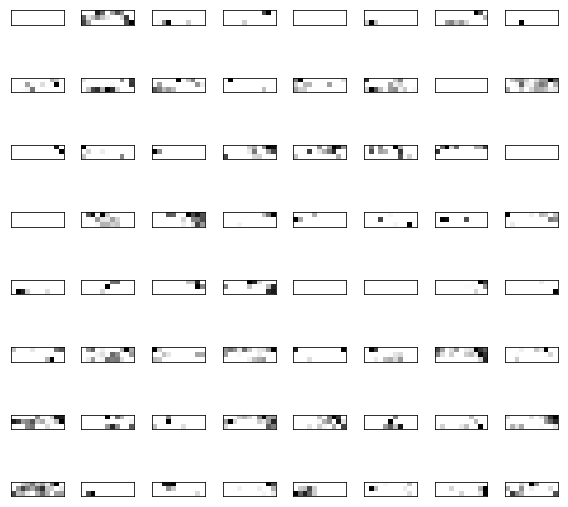

In [27]:
plt.imshow(input_image[0])
plt.title("{}".format(output_str))
plt.show()
out_layer_idx = 12
output = get_activations(model, out_layer_idx, input_image)
print(output[0].shape)
visualizing_activations(output[0],8,8).show()

## Visualizing Loss, learning trend, and sample predictions

dict_keys(['loss', 'val_loss'])


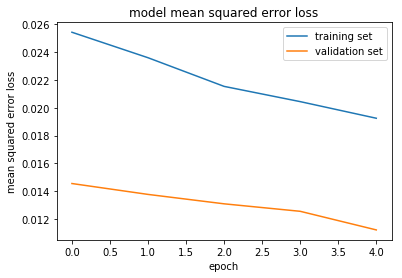

pred:-0.14350590109825134 actual:-0.13082890212535858
pred:-0.5284291505813599 actual:-0.3404655009508133
pred:0.010480041615664959 actual:0.09773462265729904
pred:-0.08113003522157669 actual:0.09255479276180267
pred:-0.04035795480012894 actual:-0.03514359891414642
pred:-0.1151411309838295 actual:-0.16701379418373108
pred:-0.1510857790708542 actual:0.09255479276180267
pred:0.34376421570777893 actual:0.378739595413208
pred:0.4526773989200592 actual:0.3404655009508133
pred:0.07950524985790253 actual:0.16701379418373108
pred:-0.3010057508945465 actual:-0.378739595413208
pred:0.07847671210765839 actual:0.128739595413208
pred:0.22050225734710693 actual:0.5784605741500854


In [28]:
%matplotlib inline
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# few predictions for control
for idx,img in enumerate(X_train[:min(13,len(X_train))]):
    image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    image_array = np.asarray(image)
    pred_steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
    print("pred:{} actual:{}".format(pred_steering_angle,y_train[idx]))

K.clear_session()
 